In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


## **Hamiltonian Monte Carlo**

The Hamiltonian Monte Carlo algorithm (originally known as hybrid Monte Carlo) is a Markov chain Monte Carlo method for obtaining a sequence of random samples which converge to being distributed according to a target probability distribution for which direct sampling is difficult. This sequence can be used to estimate integrals with respect to the target distribution (expected values).

Suppose the target distribution to sample is $f(\mathbf{x})$ for $\mathbf{x} \in \mathbb{R}^d(d \geq 1)$ and a chain of samples $\mathbf{X}_0, \mathbf{X}_1, \mathbf{X}_2, \ldots$ is required.
The Hamilton's equations are

$$
\frac{\mathrm{d} x_i}{\mathrm{~d} t}=\frac{\partial H}{\partial p_i} \quad \text { and } \quad \frac{\mathrm{d} p_i}{\mathrm{~d} t}=-\frac{\partial H}{\partial x_i}
$$

where $x_i$ and $p_i$ are the $i$ th component of the position and momentum vector respectively and $H$ is the Hamiltonian. Let $M$ be a mass matrix which is symmetric and positive definite, then the Hamiltonian is

$$
H(\mathbf{x}, \mathbf{p})=U(\mathbf{x})+\frac{1}{2} \mathbf{p}^{\mathrm{T}} M^{-1} \mathbf{p}
$$

where $U(\mathbf{x})$ is the potential energy. The potential energy for a target is given as

$$
U(\mathbf{x})=-\ln f(\mathbf{x})
$$

which comes from the Boltzmann's factor.
The algorithm requires a positive integer for number of leap frog steps $L$ and a positive number for the step size $\Delta t$. Suppose the chain is at $\mathbf{X}_n=\mathbf{x}_n$. Let $\mathbf{x}_n(0)=\mathbf{x}_n$. First, a random Gaussian momentum $\mathbf{p}_n(0)$ is drawn from $\mathrm{N}(\mathbf{0}, M)$. ${ }$ Next, the particle will run under Hamiltonian dynamics for time $L \Delta t$, this is done by solving the Hamilton's equations numerically using the leap frog algorithm. The position and momentum vectors after time $\Delta t$ using the leap frog algorithm are
$$
\begin{aligned}
& \mathbf{p}_n\left(t+\frac{\Delta t}{2}\right)=\mathbf{p}_n(t)-\left.\frac{\Delta t}{2} \nabla U(\mathbf{x})\right|_{\mathbf{x}=\mathbf{x}_n(t)} \\ \\
& \mathbf{x}_n(t+\Delta t)=\mathbf{x}_n(t)+\Delta t M^{-1} \mathbf{p}_n\left(t+\frac{\Delta t}{2}\right) \\ \\
& \mathbf{p}_n(t+\Delta t)=\mathbf{p}_n\left(t+\frac{\Delta t}{2}\right)-\left.\frac{\Delta t}{2} \nabla U(\mathbf{x})\right|_{\mathbf{x}=\mathbf{x}_n(t+\Delta t)} \\
\end{aligned}
$$

These equations are to be applied to $\mathbf{x}_n(0)$ and $\mathbf{p}_n(0) L$ times to obtain $\mathbf{x}_n(L \Delta t)$ and $\mathbf{p}_n(L \Delta t)$.
The leap frog algorithm is an approximate solution to the motion of non-interacting classical particles. If exact, the solution will never change the initial randomly-generated energy distribution, as energy is conserved for each particle in the presence of a classical potential energy field. In order to reach a thermodynamic equilibrium distribution, particles must have some sort of interaction with, for example, a surrounding heat bath, so that the entire system can take on different energies with probabilities according to the Boltzmann distribution.

One way to move the system towards a thermodynamic equilibrium distribution is to change the state of the particles using the MetropolisHastings algorithm. So first, one applies the leap frog step, then a Metropolis-Hastings step.

The transition from $\mathbf{X}_n=\mathbf{x}_n$ to $\mathbf{X}_{n+1}$ is

$$
\mathbf{X}_{n+1} \mid \mathbf{X}_n=\mathbf{x}_n= \begin{cases}\mathbf{x}_n(L \Delta t) & \text { with probability } \alpha\left(\mathbf{x}_n(0), \mathbf{x}_n(L \Delta t)\right) \\ \mathbf{x}_n(0) & \text { otherwise }\end{cases}
$$

where

$$
\alpha\left(\mathbf{x}_n(0), \mathbf{x}_n(L \Delta t)\right)=\min \left(1, \frac{\exp \left[-H\left(\mathbf{x}_n(L \Delta t), \mathbf{p}_n(L \Delta t)\right)\right]}{\exp \left[-H\left(\mathbf{x}_n(0), \mathbf{p}_n(0)\right)\right]}\right)
$$

This is repeated to obtain $\mathbf{X}_{n+1}, \mathbf{X}_{n+2}, \mathbf{X}_{n+3}, \ldots$

In [4]:
data = pd.read_csv("/content/drive/MyDrive/StressLevel/better_streelevel.csv")
X = data.iloc[:,1:]
y = data['stress_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
tfd = tfp.distributions
tfb = tfp.bijectors
num_features = X_train.shape[1]
num_classes = 3
# Define multinomial logistic regression models
def multinomial_logistic_regression(features):
    coeffs_prior = tfd.Normal(loc=tf.zeros([num_features, num_classes]), scale=tf.ones([num_features, num_classes]))
    intercept_prior = tfd.Normal(loc=tf.zeros([num_classes]), scale=tf.ones([num_classes]))

    def joint_distribution_fn():
        coeffs = yield coeffs_prior
        intercept = yield intercept_prior
        logits = tf.matmul(features, coeffs) + intercept
        outcomes = yield tfd.Categorical(logits=logits)

    return tfd.JointDistributionCoroutineAutoBatched(joint_distribution_fn)

# Initialize the model
model = multinomial_logistic_regression(tf.convert_to_tensor(X_train.astype('float32')))

In [12]:
# Target logarithmic probability function
def target_log_prob_fn(coeffs, intercept):
    return model.log_prob((coeffs, intercept, tf.convert_to_tensor(y_train, dtype=tf.int32)))

In [13]:
# Initialize the state
initial_state = [tf.zeros([num_features, num_classes], dtype=tf.float32),
                 tf.zeros([num_classes], dtype=tf.float32)]

In [25]:
# Configuring the HMC Sampler
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=1,
    num_leapfrog_steps=3
)

# Adaptive step adjusters
num_burnin_steps = 400
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc_kernel,
    num_adaptation_steps=int(num_burnin_steps * 0.8)
)

In [30]:
# Sampling function
@tf.function
def run_chain():
    return tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        current_state=initial_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted
    )



num_results = 1000
# Perform sampling
samples, is_accepted = run_chain()

# Extract samples
coeffs_samples = samples[0]
intercept_samples = samples[1]

# Calculation of acceptance rate
acceptance_rate = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32)).numpy()

print(coeffs_samples.shape, intercept_samples.shape, acceptance_rate)

(1000, 15, 3) (1000, 3) 0.693


In [27]:
# Predictive functions, averaged using Bayesian modeling
def predict_with_bma(coeffs_samples, intercept_samples, X):
    # For each sample, calculate the average of the category probabilities using all parameter samples
    probs = np.mean(
        [tf.nn.softmax(tf.matmul(X, coeffs) + intercept, axis=1).numpy()
         for coeffs, intercept in zip(coeffs_samples, intercept_samples)],
        axis=0
    )
    # Select the category with the highest probability as the predicted category
    return [np.argmax(probs, axis=1), probs]


# Predict the test set and get the average probability
mean_probs = predict_with_bma(coeffs_samples, intercept_samples, tf.convert_to_tensor(X_test.astype('float32')))[1]

# Predictions on test sets
y_pred = predict_with_bma(coeffs_samples, intercept_samples, tf.convert_to_tensor(X_test.astype('float32')))[0]
# Calculate assessment indicators
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.8954545454545455
Precision: 0.8983657263077809
Recall: 0.8954545454545455
F1 Score: 0.8958810190742965
Confusion Matrix:
 [[66  8  2]
 [ 3 67  3]
 [ 2  5 64]]


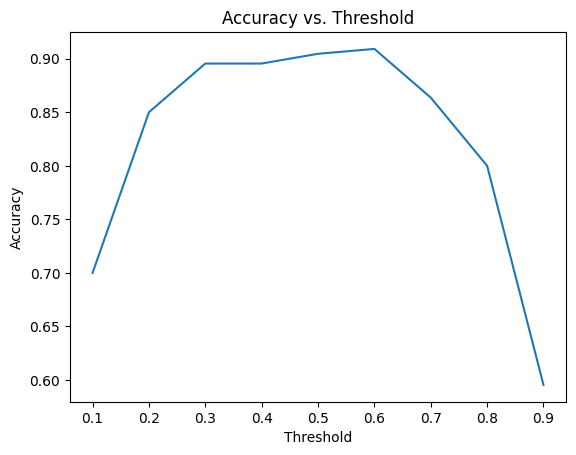

In [28]:
# Calculate accuracy at different thresholds
thresholds = np.linspace(0.1, 0.9, 9)
accuracies = []
for threshold in thresholds:
    y_pred_threshold = np.argmax(mean_probs > threshold, axis=1)
    accuracies.append(accuracy_score(y_test, y_pred_threshold))

plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.show()

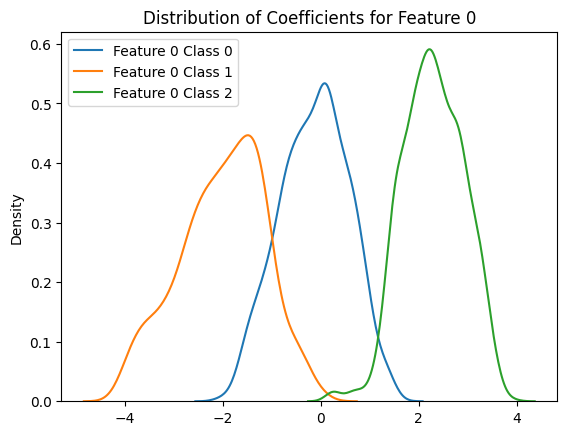

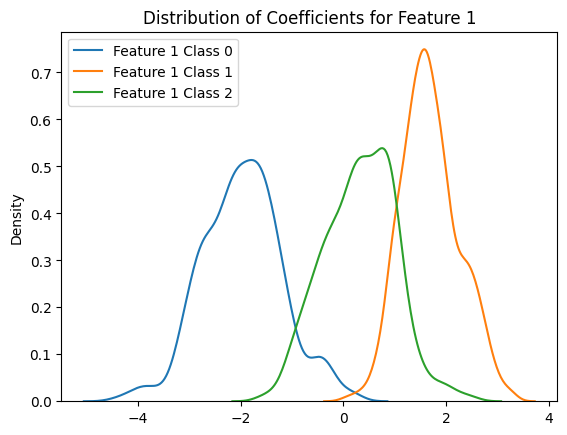

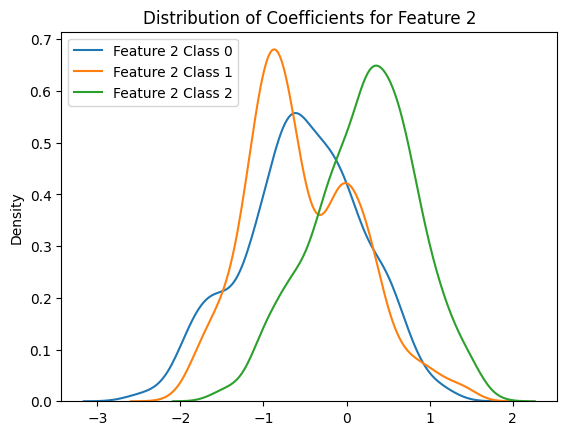

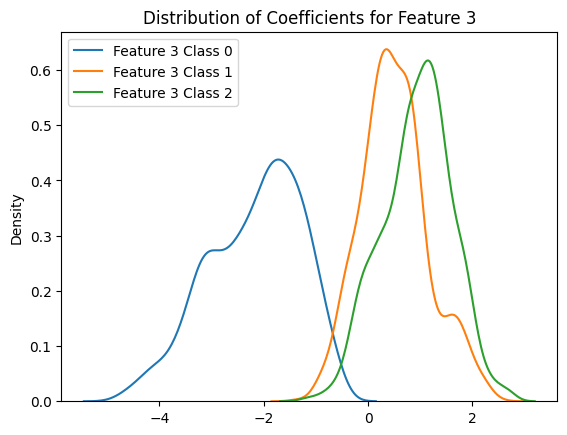

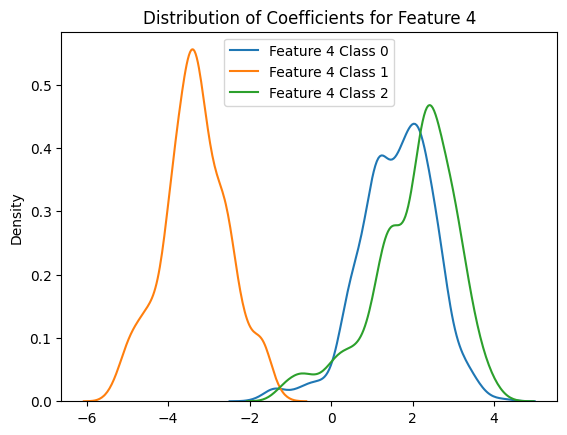

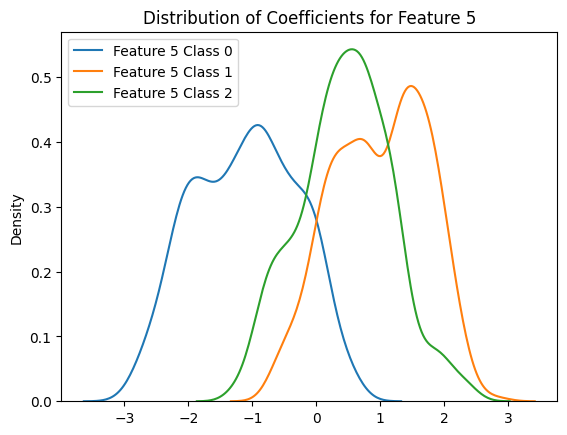

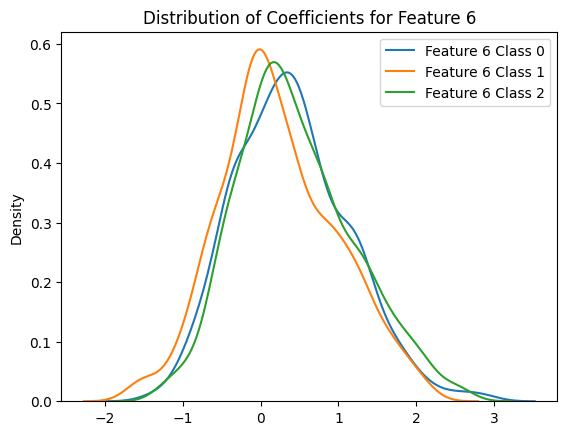

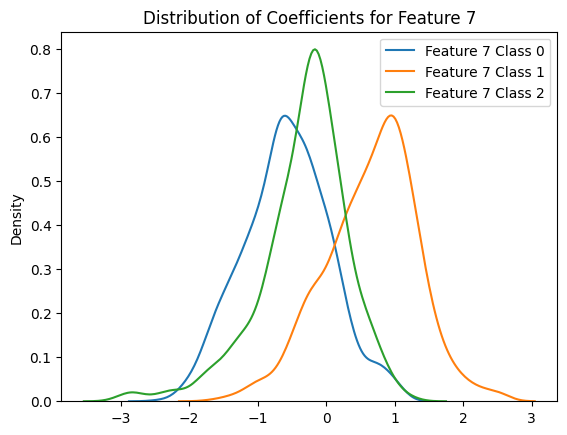

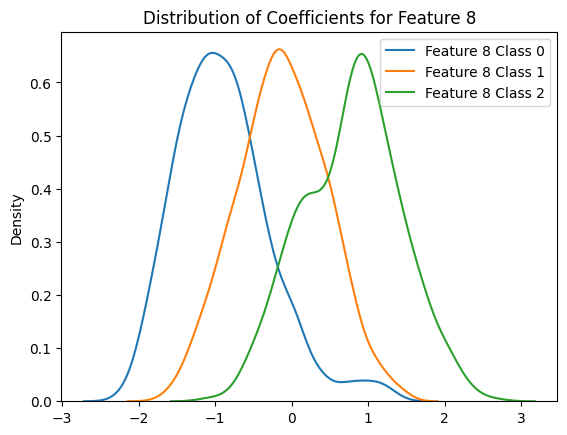

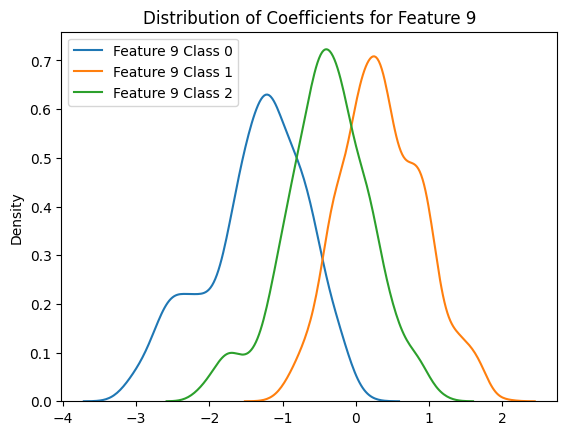

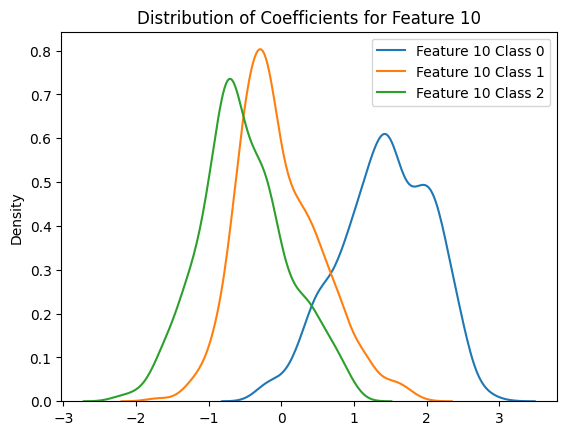

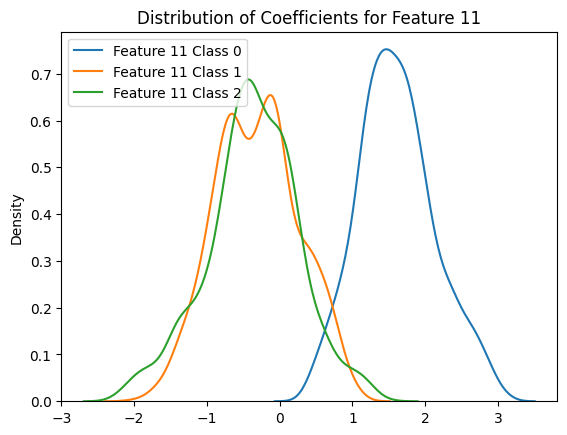

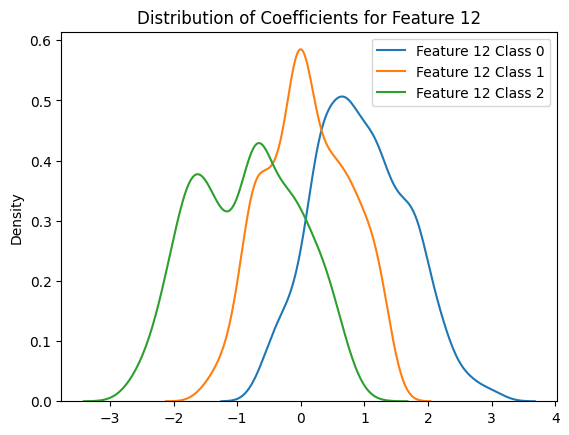

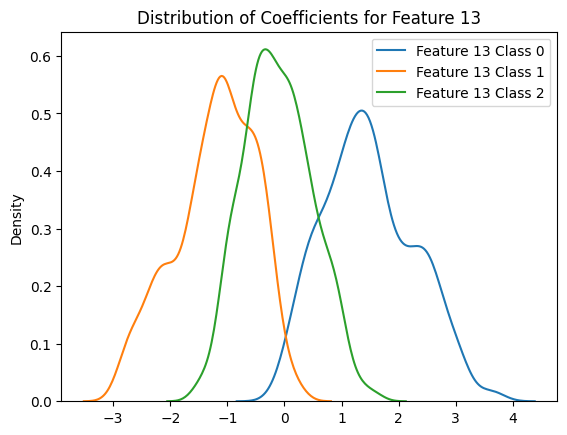

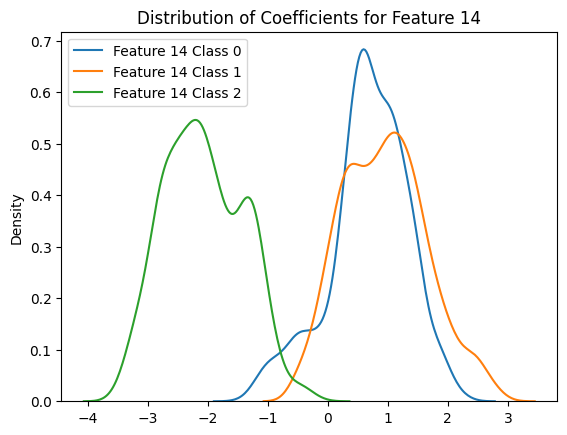

In [29]:
for i in range(num_features):
    for j in range(num_classes):
        sns.kdeplot(coeffs_samples[:, i, j], label=f'Feature {i} Class {j}')
    plt.title(f'Distribution of Coefficients for Feature {i}')
    plt.legend()
    plt.show()

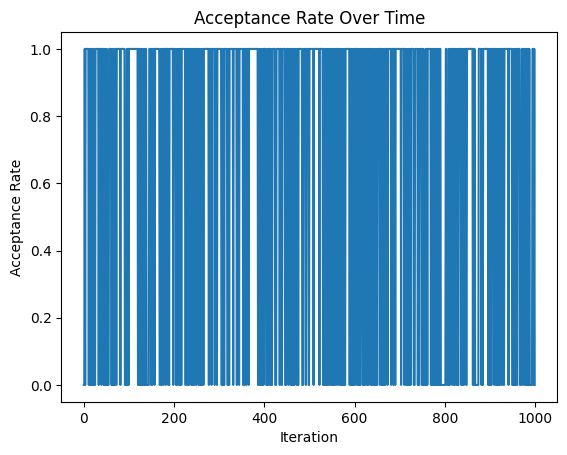

In [65]:
plt.plot(is_accepted)
plt.xlabel('Iteration')
plt.ylabel('Acceptance Rate')
plt.title('Acceptance Rate Over Time')
plt.show()